# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

root = pathlib.Path("/data")


BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

def prep_general (df, area='M1'):
    "preprocessing general!"
    
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_ = pyal.remove_low_firing_neurons(df, f"{area}_spikes", 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    
    df_ = pyal.sqrt_transform_signal(df_, f"{area}_spikes")
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


# check the multi-D array

In [3]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat']


df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
#     dt.summary(df)

In [ ]:
pairFileList_ready = [prep_general(df) for  df in df_data]
df = pairFileList_ready[0]

In [27]:
AllData1 = dt.get_data_array(pairFileList_ready, prep_epoch, area='M1', n_components=n_components)

4


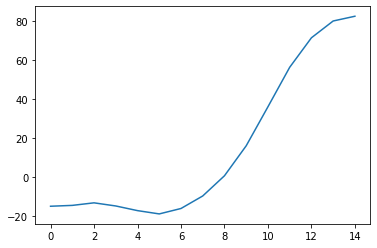

In [28]:
print(df.target_id[0])

plt.plot(AllData1[0,4,0,:,0])

In [30]:
df_ = pyal.restrict_to_interval(df, epoch_fun=prep_epoch)
rates = np.concatenate(df_['M1_rates'].values, axis=0)
rates -= np.mean(rates, axis=0)
rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
df = pyal.apply_dim_reduce_model(df_, rates_model, 'M1_rates', 'M1_pca');

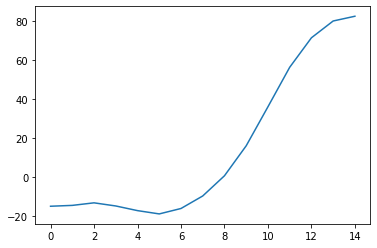

In [32]:
plt.plot(df.M1_pca[0][:,0])

In [37]:
n_t = AllData1.shape[-2]

n_t

15

In [50]:
for sessionData1 in AllData1:
    data1 = np.reshape(sessionData1[4:,:5,:,:], (-1,n_components))
data1 = np.array(data1)

data1.shape

(300, 10)

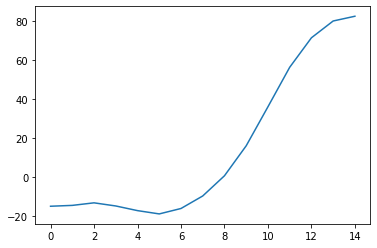

In [53]:
plt.plot(data1[:n_t,0])

# check the mouse data

In [3]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root / animal,'mat'))


df_data=[]
for fname in animalFiles[:]:
    print(fname)
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
#     dt.summary(df)

/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
array field maxRchSpeed could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
array field maxRchSpeed could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR39_100819_n

In [4]:
df = df_data[0]

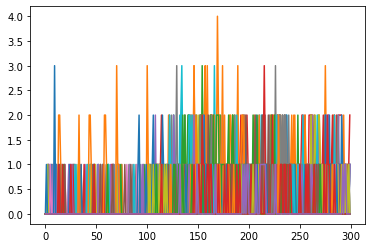

In [26]:
plt.plot(df.unitTimeBCtx[50].toarray().T[:,:]);